In [395]:
# source: https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-geospatial/methane-emission-monitoring/monitor_methane_ch4_emission_point_sources.ipynb
# https://github.com/sentinel-hub/sentinel2-cloud-detector/blob/master/examples/sentinel2-cloud-detector-example.ipynb
! pip install s2cloudless 

In [396]:
# source: https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-geospatial/methane-emission-monitoring/monitor_methane_ch4_emission_point_sources.ipynb
import os
import json
import rioxarray
import numpy as np
import pandas as pd
import geopandas as gpd
import math
import warnings
from shapely import wkt, geometry
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import IPython.display
import rasterio
from rasterio.plot import show
from sentinelhub import CRS, BBox, DataCollection, SHConfig, SentinelHubCatalog, SentinelHubRequest,MimeType, bbox_to_dimensions, MosaickingOrder, generate_evalscript# https://sentinelhub-py.readthedocs.io/en/latest/configure.html
from datetime import datetime
from typing import Any, Optional, Tuple
from s2cloudless import S2PixelCloudDetector, download_bands_and_valid_data_mask
from sentinelhub.api.catalog import get_available_timestamps

In [397]:
def bbox_around_point(lon, lat, distance_offset=1500, output_projection="EPSG:4326"):
    """
    Create a square bounding box of size distance_offset*2 by distance_offset*2
    with the provided coordinates as centroid
    """

    gs = gpd.GeoSeries(wkt.loads(f"POINT ({lon} {lat})"))
    gdf = gpd.GeoDataFrame(geometry=gs)
    gdf.crs = "EPSG:4326"
    gdf = gdf.to_crs("EPSG:3857")  # <-- change crs to a projection crs, e.g., Web Mercator
    res = gdf.buffer(
        distance=distance_offset,
        cap_style=3,  # <-- ensure sharp edges
    )

    if output_projection != "EPSG:3857":
        res = res.to_crs(output_projection)

    return res.iloc[0]

def plot_image(
    image: np.ndarray,
    factor: float = 1.0,
    clip_range: Optional[Tuple[float, float]] = None,
    **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [398]:
config = SHConfig()

config.sh_client_id = "sh-26bba4f0-3626-48f0-98af-8952fe4df97a"
config.sh_client_secret = "zGzoWVt7MBH6EH9McqkQekjVDvivWI21"
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
config.save("cdse")
# Saved config can be later accessed with config = SHConfig("cdse")

config = SHConfig("cdse")

In [543]:
# coordinates and date for North Africa oil field (common reference in earth observation literature)
# https://amt.copernicus.org/articles/14/2771/2021/
point_longitude =  130.91937389120034
point_latitude = -12.519279236018576
date_to_monitor = "2023-10-26"# "2023-10-16" 
# "2023-10-06": too much cloudy


# size of bounding box in each direction around point
distance_offset_meters = 1500

In [544]:
resolution = 10
aoi_geometry = bbox_around_point(point_longitude, point_latitude, distance_offset_meters)
# aoi_coords_wgs84 = [4.20762, 50.764694, 4.487708, 50.916455]
aoi_coords_wgs84 = list(aoi_geometry.bounds)
aoi_bbox = BBox(aoi_coords_wgs84, crs=CRS.WGS84)
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)
print(f'Image shape at {resolution} m resolution: {aoi_size} pixels')

Image shape at 10 m resolution: (295, 289) pixels


In [545]:
data_collection_new = DataCollection.SENTINEL2_L1C.define_from(
                name="s3", service_url="https://sh.dataspace.copernicus.eu"
            )
timestamps = get_available_timestamps(
    data_collection=data_collection_new, bbox=aoi_bbox, time_interval=(date_to_monitor, date_to_monitor), config=config
)
timestamps

[datetime.datetime(2023, 10, 26, 1, 40, 44, 345000),
 datetime.datetime(2023, 10, 26, 1, 40, 48, 32000)]

We download data for all suitable `timestamps`. The function `download_bands_and_valid_data` automates the process, and also uses digital number + normalization behind the scenes to reduce the costs.

In [546]:
bands, masks = download_bands_and_valid_data_mask(data_collection=data_collection_new,bbox=aoi_bbox, size=aoi_size, timestamps=timestamps, config=config)

We now repeat cloud cloud-mask calculations on the recieved data. This time we calculate the mask directly from probability maps with the `get_mask_from_prob` method.

In [547]:
cloud_detect_threshold = 0.8
cloud_detector = S2PixelCloudDetector(threshold=cloud_detect_threshold, average_over=1, dilation_size=1, all_bands=True)

probability_maps = cloud_detector.get_cloud_probability_maps(bands)
cloud_mask = cloud_detector.get_mask_from_prob(probability_maps)

Let's extract RGB bands:

In [548]:
true_color_images = np.clip(bands[..., [3, 2, 1]] * 2, 0, 1)

Let's plot cloud masks together with images:

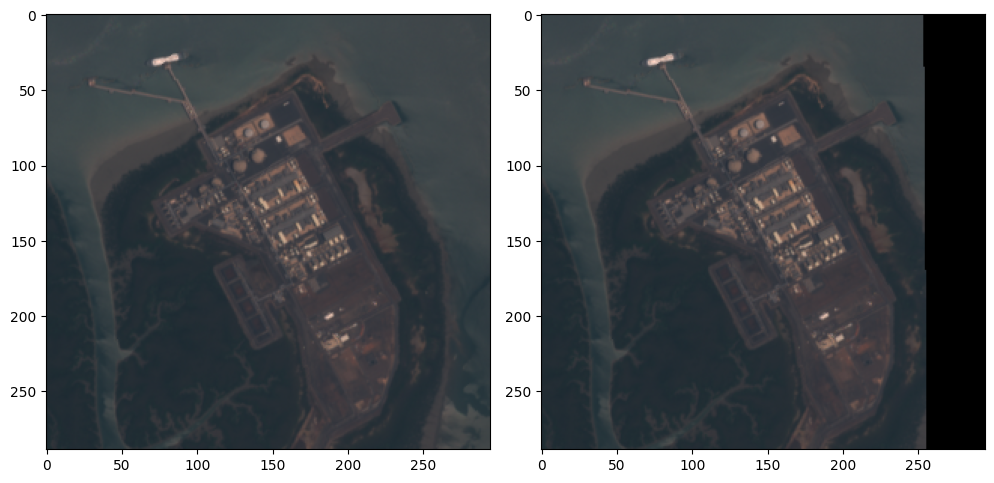

In [549]:
fig = plt.figure(figsize=(15, 10))
n_cols = 3
n_rows = int(np.ceil(len(true_color_images) / n_cols))

for idx, (image, mask) in enumerate(zip(true_color_images, cloud_mask)):
    ax = fig.add_subplot(n_rows, n_cols, idx + 1)
    ax.imshow(image)
    ax.imshow(mask, cmap="gnuplot", alpha=0.5 * (mask > 0))

plt.tight_layout()

In [550]:
def get_all_bands(point_longitude, point_latitude, distance_offset_meters, resolution, timestamps, data_collection,config, output_projection="EPSG:4326"):
    aoi_geometry = bbox_around_point(point_longitude, point_latitude, distance_offset_meters,output_projection)
    aoi_coords_wgs84 = list(aoi_geometry.bounds)
    aoi_bbox = BBox(aoi_coords_wgs84, crs=CRS.WGS84)
    aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)
    all_bands, _ = download_bands_and_valid_data_mask(data_collection=data_collection,bbox=aoi_bbox, size=aoi_size, timestamps=timestamps, config=config)
    
    cloud_detector = S2PixelCloudDetector(threshold=cloud_detect_threshold, average_over=1, dilation_size=1, all_bands=True)

    probability_maps = cloud_detector.get_cloud_probability_maps(all_bands)
    cloud_mask = cloud_detector.get_mask_from_prob(probability_maps)
    return all_bands, cloud_mask


In [551]:
# data_collection_new = DataCollection.SENTINEL2_L1C.define_from(
#                 name="s3", service_url="https://sh.dataspace.copernicus.eu"
#             )
# timestamps = get_available_timestamps(
#     data_collection=data_collection_new, bbox=aoi_bbox, time_interval=(date_to_monitor, date_to_monitor), config=config
# )
# timestamps

In [552]:
preview_distance_offset = distance_offset_meters*2
all_bands,cloud_mask = get_all_bands(point_longitude, point_latitude, preview_distance_offset, resolution*2, timestamps, data_collection_new,config)
visual_bands = all_bands[..., [3, 2, 1]]


In [553]:
rgb = visual_bands[0]
rgb = np.clip(visual_bands[0] * 2, 0,1)

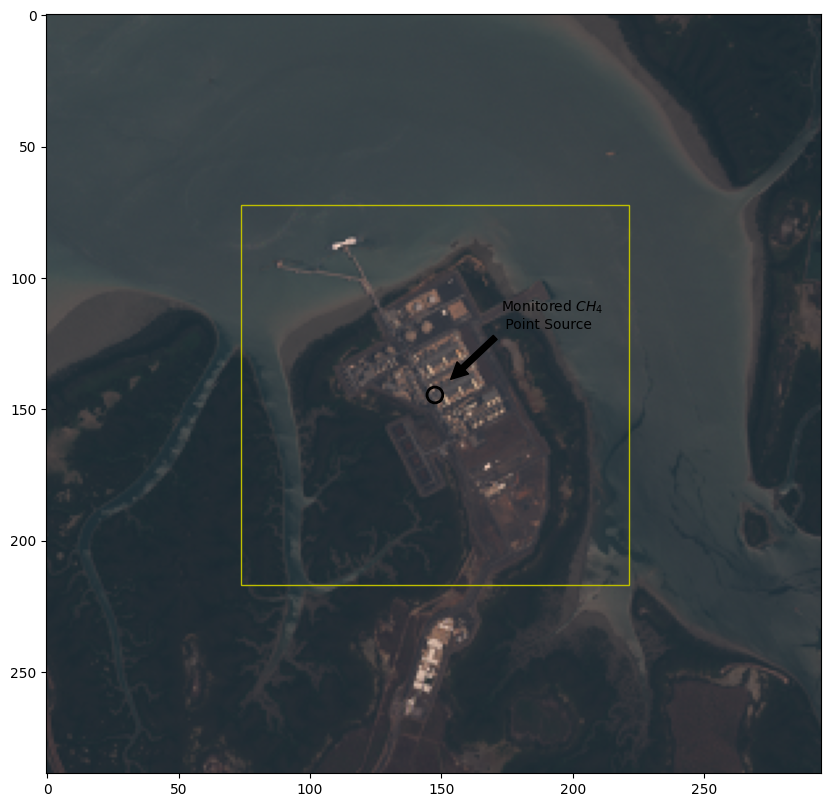

In [554]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
plt.imshow(rgb)

height = rgb.shape[0]
width = rgb.shape[1]
y_m_per_pixel = preview_distance_offset * 2 / height
x_m_per_pixel = preview_distance_offset * 2 / width

y_distance_offset = distance_offset_meters / y_m_per_pixel
x_distance_offset = distance_offset_meters / x_m_per_pixel

p = patches.Circle(
    (width / 2, height / 2), radius=3, linewidth=2, edgecolor="black", facecolor="none"
)

rect = patches.Rectangle(
    (width / 2 - x_distance_offset, height / 2 - y_distance_offset),
    x_distance_offset * 2,
    y_distance_offset * 2,
    linewidth=1,
    edgecolor="y",
    facecolor="none",
)
ax.add_patch(p)
ax.add_patch(rect)

ax.annotate(
    "Monitored $CH_4$\n Point Source",
    xy=(width / 2 + 5, height / 2 - 5),
    xytext=(width / 2 + 25, height / 2 - 25),
    arrowprops=dict(facecolor="black", shrink=0.05),
    ha="left",
)

plt.show()

## Approximate representative baseline date and corresponding Sentinel-2 tile
Our detection approach relies on observing fractional changes in the [top-of-the-atmosphere (TOA)](https://www.un-spider.org/node/10958) [short-wave infrared (SWIR)](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/resolutions/spatial) reflectance. To facilitate this, it is critical to identify a reliable baseline where the methane presence is minimal or non-existent. Establishing such a baseline can rapidly devolve into a tedious search process filled with trial and error. Fortunately, employing adept heuristics can significantly automate this process. 

One heuristic that has worked well in the investigated cases operates as follows: for the predetermined number of past days specified as `day_offset=n`, retrieve all available satellite imagery, eliminate any cloud cover, and clip the imagery to match the area of interest (AOI) in focus. Subsequently, calculate the average band-12 reflectance across the AOI and identify the Sentinel tile ID of the image showcasing the highest average reflectance in the band-12. The following functions are used to implement this approach.

In [555]:
from datetime import datetime, timedelta

def compute_new_date(date_string, day_offset):
    # Convert the input date string to a datetime object
    date = datetime.strptime(date_string, '%Y-%m-%d')
    
    # Subtract the specified number of days from the date
    new_date = date - timedelta(days=day_offset)
    
    # Format the new date as a string
    new_date_string = new_date.strftime('%Y-%m-%d')
    
    return new_date_string

### Get current band 11 and band 12 info

In [556]:
def remove_cloud_from_images(all_bands, cloud_mask):
    # Determine the number of bands
    num_bands = len(all_bands)

    # Create an empty list to store the cloud-free images
    no_cloud_images = []

    # Loop over each band and corresponding cloud mask
    for (image, mask) in zip(all_bands, cloud_mask):
        non_cloud_mask = ~(mask > 0)
        no_cloud_image = np.zeros_like(image)
        no_cloud_image[non_cloud_mask] = image[non_cloud_mask]
        no_cloud_images.append(no_cloud_image)

    # Convert the list to a NumPy ndarray
    no_cloud_images_array = np.stack(no_cloud_images, axis=0)

    return no_cloud_images_array

In [557]:
cur_timestamps = get_available_timestamps(
    data_collection=data_collection_new, bbox=aoi_bbox, time_interval=(date_to_monitor, date_to_monitor), config=config
)
cur_all_bands,cur_cloud_mask = get_all_bands(point_longitude, point_latitude, distance_offset_meters, resolution, cur_timestamps, data_collection_new,config)
cur_no_cloud_images=remove_cloud_from_images(cur_all_bands,cloud_mask)

cur_bands11 = cur_no_cloud_images[..., 11]
cur_bands12 = cur_no_cloud_images[..., 12]

# monitor_idx = -1
# l1_b11_monitor = cur_bands11[monitor_idx]
# l1_b12_monitor = cur_bands11[monitor_idx]

##### Get the best date and time from the list of timestamps based on the visible area ratio 

In [558]:
visible_area_ratio_threshold = 0.81

In [559]:
def approximate_best_timestamps(bands12,timestamps,visible_area_ratio_threshold):
    max_mean_swir = None
    sel_idx = -2
    for idx,target_band_data in enumerate(bands12):
        mean_swir = target_band_data.mean()
        visible_area_ratio = float(np.count_nonzero(target_band_data))/ float(target_band_data.shape[0]*target_band_data.shape[1])
        print(f"visible area ratio: {visible_area_ratio}" )
        if visible_area_ratio <= visible_area_ratio_threshold:
                    continue
        if max_mean_swir is None or mean_swir > max_mean_swir:
            max_mean_swir = mean_swir
            sel_idx = idx
    return timestamps[sel_idx], sel_idx

In [560]:
_,monitor_idx = approximate_best_timestamps(cur_bands12,timestamps,visible_area_ratio_threshold)
print(f"selected monitor idx: {monitor_idx}")
if monitor_idx == -2:
    raise  ValueError(f"There is no visible area with ratio higher than {visible_area_ratio_threshold}")
else:
    l1_b11_monitor = cur_bands11[monitor_idx]
    l1_b12_monitor = cur_bands12[monitor_idx]
# bands = bands[sel_idx]
# bands = bands.reshape((1,) + bands.shape) 
# masks = masks[sel_idx]
# masks = masks.reshape((1,) + masks.shape) 
# timestamps = [timestamps[sel_idx]]


visible area ratio: 1.0
visible area ratio: 0.8653920591167673
selected monitor idx: 0


In [561]:
l1_b11_monitor

array([[0.0984, 0.0986, 0.0986, ..., 0.1099, 0.1102, 0.1102],
       [0.0993, 0.0995, 0.0995, ..., 0.1078, 0.1079, 0.1079],
       [0.0993, 0.0995, 0.0995, ..., 0.1078, 0.1079, 0.1079],
       ...,
       [0.0766, 0.089 , 0.089 , ..., 0.0995, 0.0997, 0.0997],
       [0.0783, 0.0843, 0.0843, ..., 0.1034, 0.1027, 0.1027],
       [0.0783, 0.0843, 0.0843, ..., 0.1034, 0.1027, 0.1027]],
      dtype=float32)

### Get baseline band 11 and band 12 info

In [562]:
def approximate_best_baseline_date(bands12,timestamps):
    max_mean_swir = None
    sel_idx = 0
    for idx,target_band_data in enumerate(bands12):
        mean_swir = target_band_data.mean()
        visible_area_ratio = float(np.count_nonzero(target_band_data))/ float(target_band_data.shape[0]*target_band_data.shape[1])
        if visible_area_ratio <= 0.7:
                    continue
        if max_mean_swir is None or mean_swir > max_mean_swir:
            max_mean_swir = mean_swir
            sel_idx = idx
    return timestamps[sel_idx], sel_idx

In [563]:
date_offset_1 = 350
day_offset_2 = 30
baseline_enddate_to_monitor = compute_new_date(date_to_monitor, date_offset_1) # baseline end date is 350 days (date_offset_1)  from the reference date
baseline_startdate_to_monitor = compute_new_date(baseline_enddate_to_monitor, day_offset_2) # baseline start date is 30 days (date_offset_2) from baseline end date
base_timestamps = get_available_timestamps(
    data_collection=data_collection_new, bbox=aoi_bbox, time_interval=(baseline_startdate_to_monitor, baseline_enddate_to_monitor), config=config
)
base_timestamps

base_timestamps = [datetime(2022, 9, 21, 1, 40, 44, 991000)]
# base_timestamps = [datetime(2016, 7, 19, 1, 40, 41, 456000)]


In [564]:
base_all_bands,base_cloud_mask = get_all_bands(point_longitude, point_latitude, distance_offset_meters, resolution, base_timestamps, data_collection_new,config)
base_no_cloud_images=remove_cloud_from_images(base_all_bands,base_cloud_mask)
base_band11 = base_no_cloud_images[..., 11]
base_band12 = base_no_cloud_images[..., 12]

We can now use the `approximate_best_baseline_date` function to identify a suitable baseline candidate. We'll utilize the identified baseline for the computation of the change in fractional reflectances in the next steps.

In [565]:
baseline_date,sel_idx = approximate_best_baseline_date(base_band12,base_timestamps)
baseline_date

datetime.datetime(2022, 9, 21, 1, 40, 44, 991000)

In [566]:
sel_idx

0

In [567]:
l1_b11_base = base_band11[sel_idx]
l1_b12_base = base_band12[sel_idx]

In [568]:
def plot_image(
    image: np.ndarray,
    factor: float = 1.0,
    clip_range: Optional[Tuple[float, float]] = None,
    **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

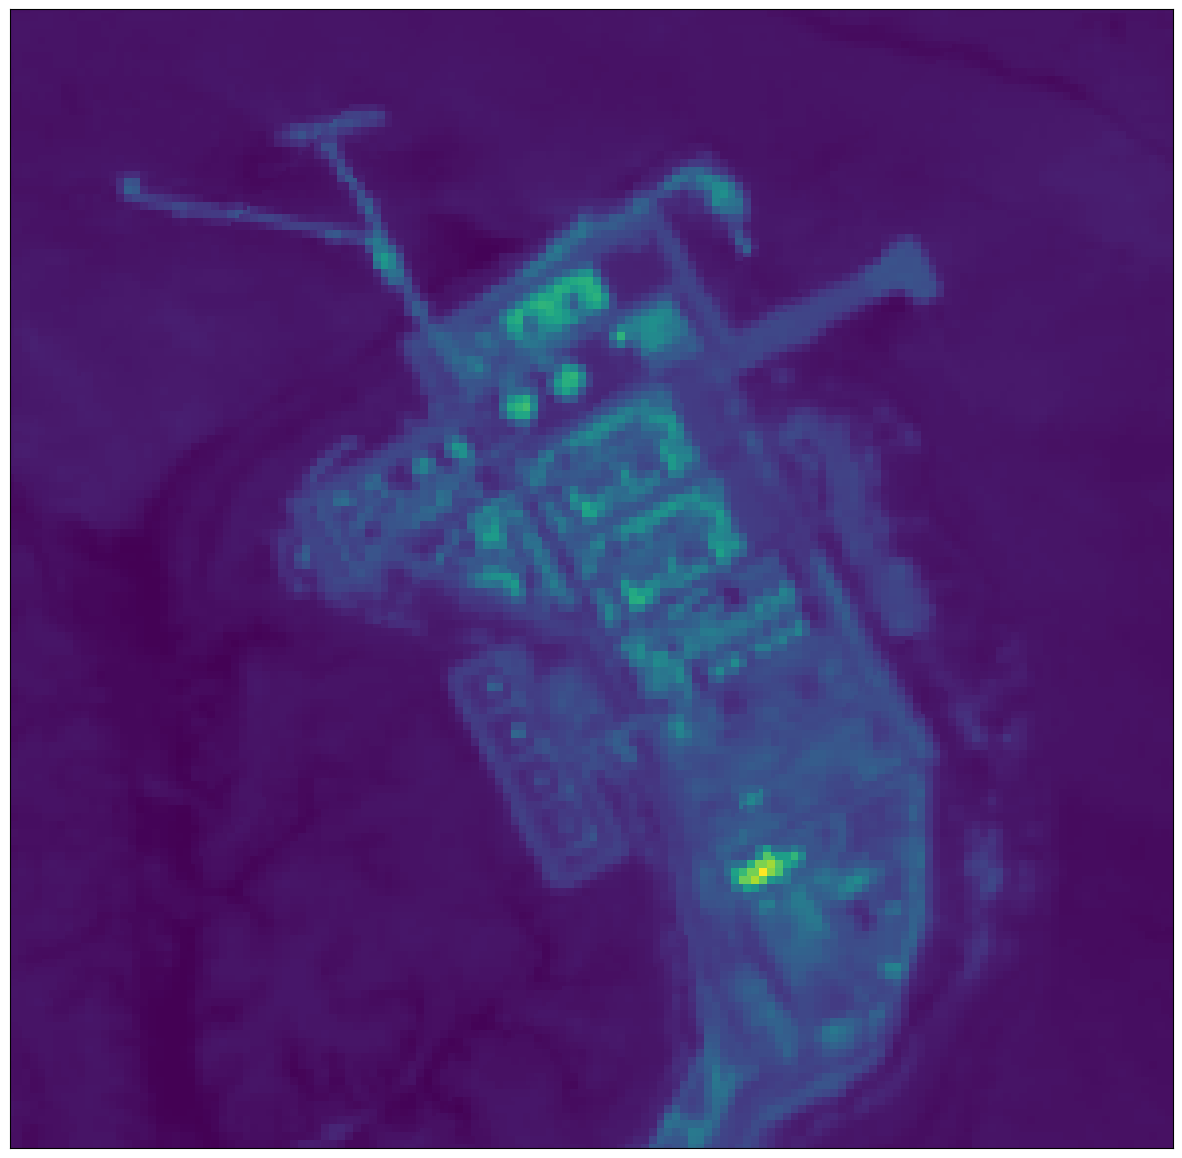

In [569]:
plot_image(l1_b12_base, factor=1, clip_range=(0, 1))

The detection method we are implementing involves calculating the fractional change in top-of-the-atmosphere (TOA) reflectance, denoted as $\Pi \rho$. This measure encompasses the reflectance recorded by the Sentinel-2 mission across two distinct satellite passes and two SWIR bands. These passes include a baseline, where no methane is presumed present (referred to as `base`), and a monitoring pass where there is suspicion of an active methane point source (referred to as `monitor`). Mathematically, we can express this as follows:

$$ \Delta \rho = -\big({c^{monitor} \rho^{monitor}_{b12} - \rho^{monitor}_{b11} \over \rho^{monitor}_{b11}}-{c^{base} \rho^{base}_{b12} - \rho^{base}_{b11} \over \rho^{base}_{b11}}\big)$$

where $\rho$ represents the TOA reflectance as measured by Sentinel-2. The correction factors $c^{monitor}$ and $c^{base}$ are determined by regressing TOA reflectance values of band-12 against those of band-11 across the entire scene, denoted mathematically as $\rho_{b11} = c × \rho_{b12}$

The following functions implement the described approach.

In [570]:
def compute_correction_factor(tif_y, tif_x):
    """
    Compute a correction factor c via linera regression
    with the following equation: tif_y = c*tif_x
    """

    # get flattened arrays for regression
    y = tif_y.flatten()
    x = tif_x.flatten()

    np.nan_to_num(y, copy=False)
    np.nan_to_num(x, copy=False)

    assert y.shape == x.shape, "Shapes of two provided TIFs are incompatible!"

    # fit linear model using least squares regression
    x = x[:, np.newaxis]
    c, _, _, _ = np.linalg.lstsq(x, y, rcond=None)

    return c[0]
def compute_corrected_fractional_reflectance_change(
    l1_b11_base, l1_b12_base, l1_b11_monitor, l1_b12_monitor, correction=True
):
    """
    Compute multi-band-multi-pass fractional reflectance change
    between base and monitoring scene
    """
    # get correction factor
    c_monitor = compute_correction_factor(tif_y=l1_b11_monitor, tif_x=l1_b12_monitor)
    c_base = compute_correction_factor(tif_y=l1_b11_base, tif_x=l1_b12_base)

    # get corrected fractional reflectance change
    if correction:
        frac_change = -((c_monitor * l1_b12_monitor - l1_b11_monitor) / l1_b11_monitor) - (
            (c_base * l1_b12_base - l1_b11_base) / l1_b11_base
        )
    else:
        frac_change = -((l1_b12_monitor - l1_b11_monitor) / l1_b11_monitor) - (
            (l1_b12_base - l1_b11_base) / l1_b11_base
        )
    return frac_change

In [571]:
l1_b11_monitor.flatten()

array([0.0984, 0.0986, 0.0986, ..., 0.1034, 0.1027, 0.1027], dtype=float32)

In [572]:
frac_change = compute_corrected_fractional_reflectance_change(l1_b11_base, l1_b12_base, l1_b11_monitor, l1_b12_monitor)
frac_change

array([[-0.12958363, -0.11845335, -0.11845335, ..., -0.08754803,
        -0.11466479, -0.11466479],
       [-0.11137865, -0.15070702, -0.15070702, ..., -0.12617832,
        -0.1905404 , -0.1905404 ],
       [-0.11137865, -0.15070702, -0.15070702, ..., -0.12617832,
        -0.1905404 , -0.1905404 ],
       ...,
       [ 0.8911357 ,  0.92507625,  0.92507625, ..., -0.09993068,
        -0.07947019, -0.07947019],
       [ 0.833206  ,  0.9686209 ,  0.9686209 , ..., -0.08701263,
        -0.12013695, -0.12013695],
       [ 0.833206  ,  0.9686209 ,  0.9686209 , ..., -0.08701263,
        -0.12013695, -0.12013695]], dtype=float32)

In [573]:
def nan_ptp(a):
    return np.ptp(a[np.isfinite(a)])

In [574]:
# normalise frac_change
frac_change_norm = (frac_change - np.nanmin(frac_change))/nan_ptp(frac_change)
frac_change_norm
# # Normalised [0,255] as integer: don't forget the parenthesis before astype(int)
# frac_change_int = (255*frac_change_norm).astype(int)   
# frac_change_int

array([[0.72306573, 0.72554344, 0.72554344, ..., 0.73242325, 0.7263868 ,
        0.7263868 ],
       [0.7271183 , 0.71836346, 0.71836346, ..., 0.7238238 , 0.7094962 ,
        0.7094962 ],
       [0.7271183 , 0.71836346, 0.71836346, ..., 0.7238238 , 0.7094962 ,
        0.7094962 ],
       ...,
       [0.9502872 , 0.95784265, 0.95784265, ..., 0.7296667 , 0.73422146,
        0.73422146],
       [0.9373915 , 0.96753615, 0.96753615, ..., 0.73254246, 0.72516865,
        0.72516865],
       [0.9373915 , 0.96753615, 0.96753615, ..., 0.73254246, 0.72516865,
        0.72516865]], dtype=float32)

In [575]:
np.nanmean(frac_change_norm)

0.8041748

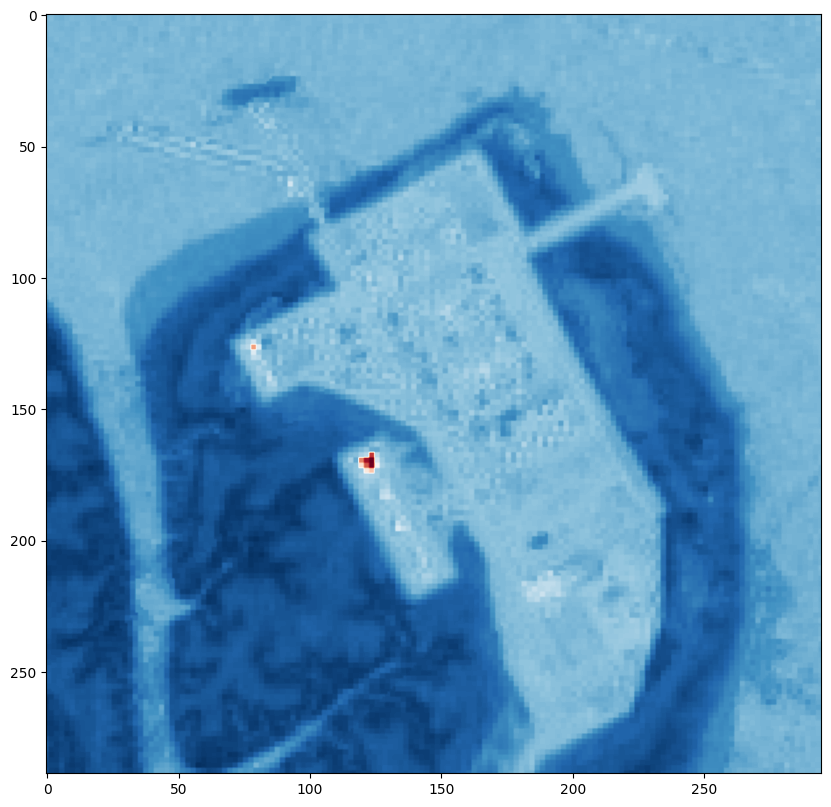

In [576]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(frac_change, cmap="RdBu")

### Compute the adaptive upper threshold & Plot the distribution of frac_change_norn

In [577]:

data_flat = frac_change_norm.ravel() # Flatten the 2D array into a 1D array

total_count = len(data_flat) # Total number of elements
# Calculate the histogram (number of occurrences in each bin)
counts, bins = np.histogram(data_flat, bins=20, range=(0, 1))
# Convert counts to probabilities (normalized by total count)
probabilities = counts / total_count


In [578]:
# using KMeans to fit the data
from sklearn.cluster import KMeans
km = KMeans()
km_fit = km.fit(probabilities.reshape(-1,1))

In [579]:
# Find the adaptive threshold
num_of_considered_bins = 15 # out of 20 bins, only consider 16 bins, i.e., 80% of the bin since the 20% remaining bins should be noise. 
km_labels  = km_fit.labels_
# Find unique values and their counts
unique_label_values, label_counts = np.unique(km_labels, return_counts=True)

# Get the value with the smallest value
label_with_smallest_value = unique_label_values[np.argmin(km_fit.cluster_centers_)]
print("Label Value with the smallest value:", label_with_smallest_value)

km_labels_check = km_labels == label_with_smallest_value
km_labels_check = km_labels_check[0:num_of_considered_bins]
bins_new = bins[0:num_of_considered_bins]
adaptive_upper_threshold = np.max(bins_new[km_labels_check]) * 1.0
print("adaptive_upper_threshold :", adaptive_upper_threshold)

Label Value with the smallest value: 0
adaptive_upper_threshold : 0.6000000238418579


In [580]:
unique_label_values[np.argmin(km_fit.cluster_centers_)]

0

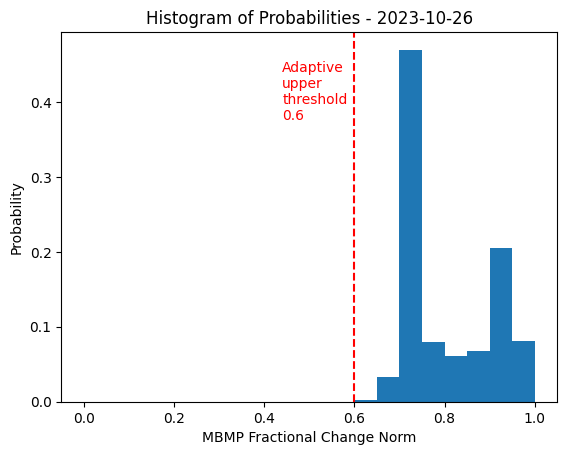

In [581]:
# Plot the probabilities (bar graph) and bins (centers)
plt.bar(bins[:-1] + (bins[1] - bins[0]) / 2, probabilities, width=(bins[1] - bins[0]))  # Center bars on bins
# Add a vertical line at x = adaptive_upper_threshold
plt.axvline(x=adaptive_upper_threshold, color='r', linestyle='--')
plt.text(adaptive_upper_threshold-0.16, max(probabilities) * 0.8, f'Adaptive\nupper\nthreshold\n{np.round(adaptive_upper_threshold,3)}', color='r')
plt.xlabel("MBMP Fractional Change Norm")
plt.ylabel("Probability")
plt.title(f"Histogram of Probabilities - {date_to_monitor}")
plt.savefig(r"MBMP_Frac_change_norm_" +date_to_monitor +'.png', bbox_inches='tight')
plt.show()

## Compare visual imagery with detected plume mask
As a final step, we will extract the identified methane plume and overlay it on a raw RGB satellite image to contextualize it geographically. This is achievable through thresholding.

In our instance, applying a threshold of -0.025 to the fractional change in reflectance yields good results for the observed scene. Nevertheless, it is important to note that the optimal threshold may vary from scene to scene, requiring calibration tailored to your specific use case. The following cell creates a visualization that incorporates the original RGB image, the computed plume mask, and a composite image that shows the methane plume within its geographical context.

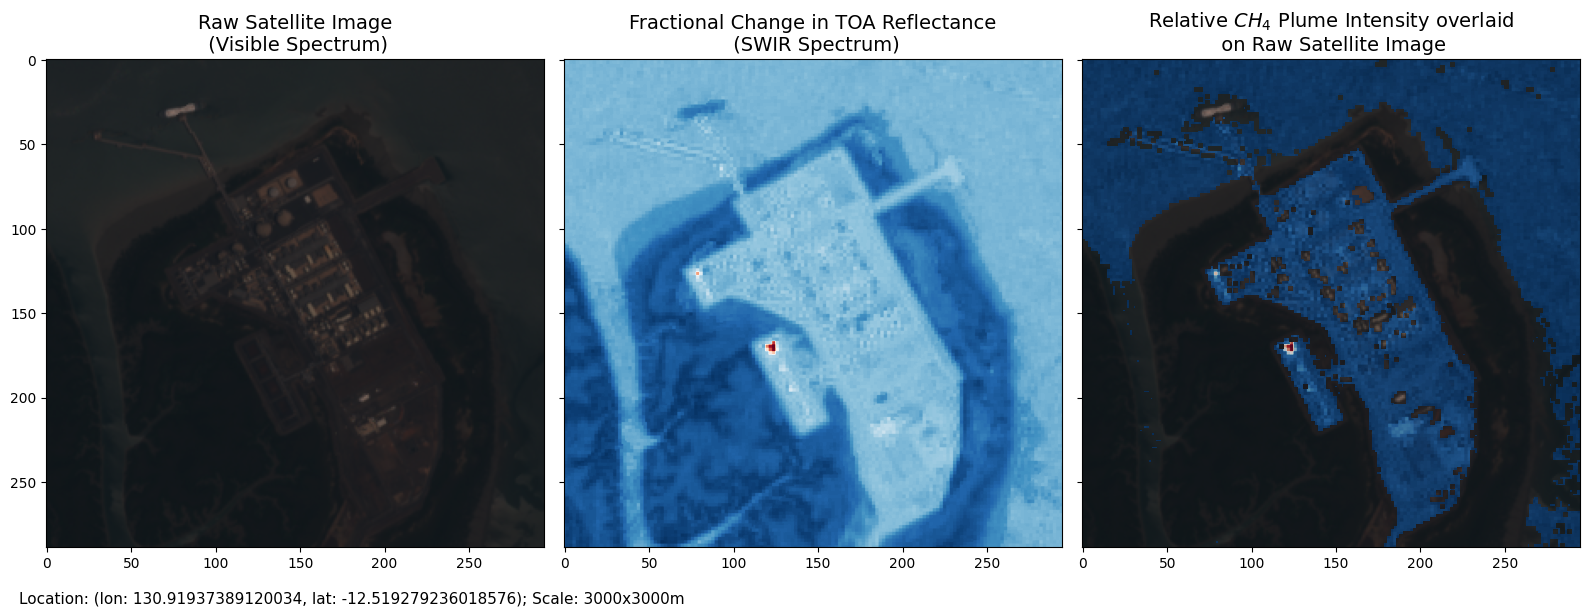

In [582]:
treshold_value = -0.028
visual_bands = cur_no_cloud_images[..., [3, 2, 1]]
rgb = visual_bands[0]


cr_masked = frac_change.copy()
cr_masked[cr_masked > treshold_value] = np.nan

m = np.ma.array(cr_masked, mask=cr_masked == np.nan)


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 10), sharex=True, sharey=True)

ax = axes[0]
ax.imshow(rgb)
ax.set_title("Raw Satellite Image\n (Visible Spectrum)", fontsize=14)

ax = axes[1]
ax.imshow(frac_change, cmap="RdBu")  # <-- uses interpolated data
ax.set_title("Fractional Change in TOA Reflectance\n (SWIR Spectrum)", fontsize=14)

ax = axes[2]
ax.imshow(rgb)
ax.imshow(m, alpha=0.8, cmap="RdBu")
ax.set_title("Relative $CH_4$ Plume Intensity overlaid\n on Raw Satellite Image", fontsize=14)

for ax in axes:
    ax.grid(False)
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])
txt = f"Location: (lon: {point_longitude}, lat: {point_latitude}); Scale: {distance_offset_meters*2}x{distance_offset_meters*2}m"
# txt = f"Location: (lon: {point_longitude}, lat: {point_latitude}); Reference Tile Id: {change_reflectance.attrs['s2_tile_id_baseline']}; Monitoring Tile Id: {change_reflectance.attrs['s2_tile_id_monitor']}; Scale: {distance_offset_meters*2}x{distance_offset_meters*2}m"
# plt.figtext(0.015, 0.25, txt, wrap=False, horizontalalignment="left", fontsize=11)
plt.figtext(0.015, 0.2, txt, wrap=False, horizontalalignment="left", fontsize=11)

plt.tight_layout()

plt.show()

In [583]:
import cv2
import numpy as np

def segment_by_color(image, lower_thresh, upper_thresh):
    # Threshold the single-channel image to get only specified color
    mask = cv2.inRange(image, lower_thresh, upper_thresh)
    return mask

def find_contours(mask):
    # Find contours in the mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def merge_masks(masks):
    # Combine all masks into one mask
    merged_mask = np.zeros_like(masks[0], dtype=np.uint8)
    for mask in masks:
        merged_mask = cv2.bitwise_or(merged_mask, mask)
    return merged_mask

def extract_values(image, contours):
    values = []
    for contour in contours:
        mask = np.zeros_like(image, dtype=np.uint8)
        cv2.drawContours(mask, [contour], -1, 255, -1)  # Draw contour on the mask
        contour_values = image.copy()
        contour_values[mask == 0] = np.nan # Set values outside the contour to NaN
        values.append(np.nanmean(contour_values))  # Compute sum of pixel values within the contour
    return values

def extract_values_sum(image, contours):
    values = []
    for contour in contours:
        mask = np.zeros_like(image, dtype=np.uint8)
        cv2.drawContours(mask, [contour], -1, 255, -1)  # Draw contour on the mask
        contour_values = image.copy()
        contour_values[mask == 0] = np.nan # Set values outside the contour to NaN
        values.append(np.namsum(contour_values))  # Compute sum of pixel values within the contour
    return values

def filter_contours(contours, values, threshold):
    filtered_contours = []
    filtered_values = []
    for contour, value in zip(contours, values):
        if value <= threshold:
            filtered_contours.append(contour)
            filtered_values.append(value)
    return filtered_contours, filtered_values

def compute_centroids(contours):
    centroids = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"]/M["m00"])
            cY = int(M["m01"]/M["m00"])
            centroids.append((cX,cY))
        else:
            # set centroid to (-1,-1) if the contour has no area
            centroids.append((-1,-1))
    return centroids

def convert_centroid_to_latlon(centroids,center_lat,center_lon,distance_offset_meters,image_size):

    # Physical size of the image in meters
    image_width = distance_offset_meters*2  # meters
    image_height = distance_offset_meters*2  # meters
    # Compute the conversion factor between meters and pixels for both latitude and longitude directions

    centroids_gps = []
    
    for centroid_xy in centroids:
       
        # Compute centroid in pixel coordinates (relative to the center)
        # Calculate the pixel location in meters from the center
        pixel_x = (centroid_xy[0] - image_size[0] // 2) * (image_width / image_size[0])
        pixel_y = (centroid_xy[1] - image_size[1] // 2) * (image_height / image_size[1])

        
        # Convert pixel location to latitude and longitude
        pixel_lat = center_lat - (pixel_y / 110540)  # Approximate conversion, 1 degree ~ 111,111 meters
        pixel_lon = center_lon + (pixel_x / (111320  * np.cos(np.radians(center_lat))))
        centroid_lat_lon = (pixel_lat,pixel_lon)
        centroids_gps.append(centroid_lat_lon)
        print("Centroid coordinates (latitude, longitude):", centroid_lat_lon)
    return centroids_gps

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Average values inside each contour: [0.5712259, 0.27200478, 0.47372523, 0.5982997]
Average values inside each filtered contour: [0.27200478, 0.47372523]
Total frac change values inside each filtered contour: [-2.1558301, -1.2496656]
centroid of contours:  [(122, 170), (79, 127)]


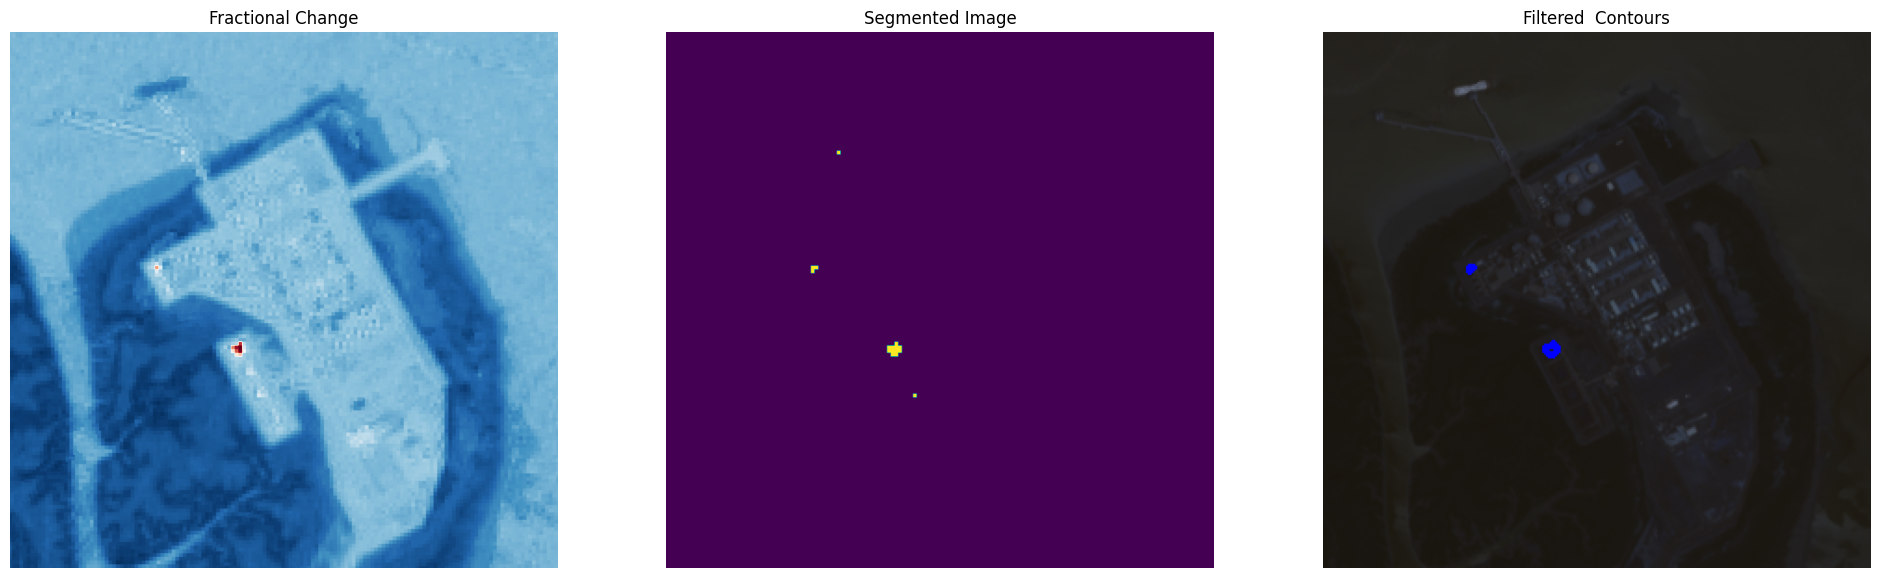

In [584]:
# Load the single-channel image
# normalise frac_change
frac_change_norm = (frac_change - np.nanmin(frac_change))/nan_ptp(frac_change)
image = frac_change_norm; #cv2.imread('single_channel_image.jpg', cv2.IMREAD_GRAYSCALE)  # Replace 'single_channel_image.jpg' with the path to your single-channel image

# Define the lower and upper thresholds of the color you want to segment
lower_thresh = 0  # Example: Lower threshold for segmentation
upper_thresh = adaptive_upper_threshold #0.4  # Example: Upper threshold for segmentation

# Perform color segmentation
mask = segment_by_color(image, lower_thresh, upper_thresh)

# Find contours in the mask
contours = find_contours(mask)

# Draw contours on the original image
result = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
cv2.drawContours(result, contours, -1, (0, 255, 0), 2)

# Extract values inside each contour
contour_values = extract_values(image,contours)
print("Average values inside each contour:", contour_values)

# Set the threshold for contour filtering
threshold = 0.95*adaptive_upper_threshold #0.4 #0.31  # Example threshold value

# Filter contours based on the threshold
filtered_contours, filtered_values = filter_contours(contours, contour_values, threshold)

print("Average values inside each filtered contour:", filtered_values)

sum_frac_change_value = extract_values(frac_change.copy(),filtered_contours)

print("Total frac change values inside each filtered contour:", sum_frac_change_value)

# Compute centroids of filtered contours
centroids = compute_centroids(filtered_contours)

print("centroid of contours: ",centroids)

# Draw filtered contours on the original image
filtered_result = rgb.copy()
cv2.drawContours(filtered_result, filtered_contours, -1, (255, 0, 0), 2)

# Draw centroids on the original image
# for centroid in centroids:
# cv2.circle(filtered_result, centroid, 5, (0, 0, 255), -1)

# Display the result using Matplotlib
plt.figure(figsize=(24, 12))
plt.subplot(131)
plt.imshow(image, cmap='RdBu')
plt.title('Fractional Change')
plt.axis('off')                                                              

plt.subplot(132)
plt.imshow(mask, cmap='viridis')
plt.title('Segmented Image')
plt.axis('off')

plt.subplot(133)
plt.imshow(cv2.cvtColor(filtered_result, cv2.COLOR_BGR2RGB))
plt.title('Filtered  Contours')
plt.axis('off')

plt.savefig(r"MBMP_Darwin" +date_to_monitor +'.png', bbox_inches='tight')
plt.show()

### Compute contour absolute positions in GPS and export them to csv file

In [585]:
centroids_gps_latlon = convert_centroid_to_latlon(centroids,point_latitude,point_longitude,distance_offset_meters,aoi_size)

Centroid coordinates (latitude, longitude): (-12.521720851666954, 130.91703442400612)
Centroid coordinates (latitude, longitude): (-12.517682795017715, 130.91301054043205)


In [586]:
import csv

def generate_csv(date_to_monitor, centroids, filtered_values, sum_frac_change_value, filename):
    with open(filename, 'w', newline='') as csvfile:
        fieldnames = ['date_to_monitor', 'lat', 'lon', 'avg_norm_frac_change', 'total_frac_change']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        
        writer.writeheader()
        for centroid, filtered_value, frac_change_value in zip(centroids, filtered_values, sum_frac_change_value):
            writer.writerow({'date_to_monitor': date_to_monitor,
                             'lat': centroid[0],
                             'lon': centroid[1],
                             'avg_norm_frac_change': filtered_value,
                             'total_frac_change': frac_change_value})

In [587]:
import os

# Get the current working directory
current_dir = os.getcwd()
print(current_dir)

/usr/src/app/flow_rate_analysis


In [588]:
filename = f"{current_dir}/MBMP_methane_data_{date_to_monitor}_lat_{point_latitude}_lon_{point_longitude}.csv"
filename

'/usr/src/app/flow_rate_analysis/MBMP_methane_data_2023-10-26_lat_-12.519279236018576_lon_130.91937389120034.csv'

In [589]:
generate_csv(date_to_monitor, centroids_gps_latlon, filtered_values, sum_frac_change_value, filename)

##### Combine all CSV files into one file

In [590]:
import csv
import glob

# Define the output filename
output_filename = "MBMP_combined.csv"

# Get all CSV files in the current directory
csv_files = glob.glob("MBMP_methane_*.csv")

# Open the output file for writing in append mode ('a') and with newline='' to avoid extra newlines
with open(output_filename, 'a', newline='') as output_file:
  # Open the first CSV file to check the header
  with open(csv_files[0], 'r') as first_file:
    reader = csv.reader(first_file)
    header = next(reader)  # Read the header from the first file

    # Write the header to the output file only if it's the first time
    writer = csv.writer(output_file)
    writer.writerow(header)

  # Loop through all CSV files
  for filename in csv_files:
    # Skip the first file (already processed for header)
    if filename == csv_files[0]:
      continue

    # Open the current file and read data (skip header)
    with open(filename, 'r') as current_file:
      reader = csv.reader(current_file)
      next(reader)  # Skip the header of the current file
      data = list(reader)

      # Write the data to the output file
      writer.writerows(data)

print(f"CSV files combined into '{output_filename}'.")


CSV files combined into 'MBMP_combined.csv'.
